## Final Project Submission

Please fill out:
* Student name: Seyma Tas
* Student pace: full time
* Scheduled project review date/time: 
* Instructor name: Amber Yandow
* Blog post URL:


This is the first modelling notebook. This notebook contains .......

##### Import the necessary libraries.

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ParameterGrid
from sklearn.linear_model import LogisticRegression, SGDClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.metrics import recall_score, f1_score,fbeta_score, r2_score, roc_auc_score, roc_curve, auc, cohen_kappa_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
import xgboost as xgb
# from sklearn.metrics import plot_confusion_matrix

import warnings
warnings.filterwarnings('ignore')

##### Download the data set which was cleaned, unnecessary columns are omitted and one hot encoded.

In [6]:
df = pd.read_csv('TelcoCustomerChurnData_cleaned_ohe.csv')

In [7]:
df.head()

,tenure,MonthlyCharges,TotalCharges,Churn,SeniorCitizen_1,Partner_Yes,Dependents_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,...,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.85,29.85,0,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
1,34,56.95,1889.50,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,2,53.85,108.15,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,45,42.30,1840.75,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,0,0
4,2,70.70,151.65,1,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0


### Splitting the data into test and train sets

In [8]:
X = df.drop(['Churn'], axis=1)
y = df['Churn']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Scaling the data by sklearn Standard Scaler

In [10]:
scaler = StandardScaler()
scaled_x_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)
scaled_X_train = pd.DataFrame(scaled_x_train, columns=X_train.columns)


### Functions to evaluate the model

##### Function to draw the ROC curve and to calculate the area under the curve

In [11]:
def roc_curve_and_auc(clf, X_train, X_test, y_train, y_test):

    # Calculate the probability scores of each point in the training set
    y_train_score = clf.fit(X_train, y_train).decision_function(X_train)

    # Calculate the fpr, tpr, and thresholds for the training set
    train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_score)

    # Calculate the probability scores of each point in the test set
    y_test_score = clf.decision_function(X_test)

    # Calculate the fpr, tpr, and thresholds for the test set
    test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)

    # ROC curve for training set
    plt.figure(figsize=(10, 8))
    lw = 2
    plt.plot(train_fpr, train_tpr, color='darkorange',
             lw=lw, label='Train ROC curve')
    plt.plot(test_fpr, test_tpr, color='blue',
             lw=lw, label='Test ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve for Training and Testing Sets')
    plt.legend(loc='lower right')
    plt.show()
    # Print the area under the roc curve
    print('Training AUC: {}'.format(round(auc(train_fpr, train_tpr), 5)))
    print('Testing AUC: {}'.format(round(auc(test_fpr, test_tpr), 5)))

##### Function to draw the feature importances

In [12]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

##### Function to print the confusion matrix in a data frame to make the matrix more readable.

In [ ]:
 def confusion_matrix_df(y_test, y_pred_test):
    confusion_mat = confusion_matrix(y_test, y_pred_test, labels=[0, 1])
    _row = confusion_mat.sum(axis=0)
    _col = [np.nan] + list(confusion_mat.sum(axis=1)) + [sum(_row)]
    con_df = pd.DataFrame({})
    con_df["Predicted"] = ["Actual"] + ["No Churn", "Churn"] + ["All"]
    for label, idx in {"No Churn": 0, "Churn": 1}.items():
        temp = [np.nan] + list(confusion_mat[:, idx]) + [_row[idx]]
        con_df[label] = temp

    con_df["All"] = _col
    return con_df

##### Function to print the metrics including Confusion Matrix, Classification Report, Cohen's Kappa, F beta score, roc-auc score and mean cross validation score.

In [14]:
def model_evaluation(X_train, X_test, y_train, y_test, y_pred_train, y_pred_test):

    print('MODEL EVALUATION METRICS:\n',
          '-----------------------------------------------------')
    
    print('Confusion Matrix for train & test set: \n')
    print(confusion_matrix_df(y_train, y_pred_train), '\n')
    print(confusion_matrix_df(y_test, y_pred_test),'\n')
   
    print('-----------------------------------------------------')
    print('\nClassification Report for train & test set\n',
          '\nTrain set\n',
          classification_report(y_train, y_pred_train),
          '\n\nTest set\n',
          classification_report(y_test, y_pred_test))
 
    print('-----------------------------------------------------\n')
    print("Cohen's Kappa for train and test set:\n ",
            round(cohen_kappa_score(y_train, y_pred_train), 4),
            round(cohen_kappa_score(y_test, y_pred_test), 4))

    print ("f2 score for train and test set: \n ",
           round(fbeta_score(y_train, y_pred_train, 2.0),4), 
           round(fbeta_score(y_test, y_pred_test, 2.0),4))
    
    print ('roc auc score for train and test set:\n ', 
           round(roc_auc_score(y_train, y_pred_train),4),
           round(roc_auc_score(y_test, y_pred_test),4) )
    
    print('Mean Cross Validation Score:\n', round(cross_val_score(clf, X, y, cv=5).mean(), 4))   

# MODELLING

### Handling Imbalanced Data

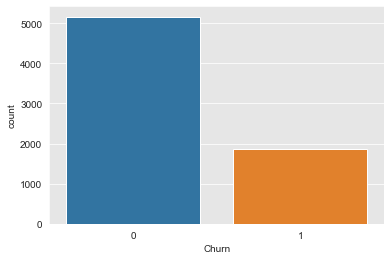

In [29]:
sns.countplot(y);

In [ ]:
y.value_counts(normalize=True)

We have an imbalanced data. We have to find ways to handle it or we are going to have a high accuracy but we can not make true predictions of the minority class which is 'Churn' in this project. 
We can use class_weight parameter of the models, we can make synthetic samples of the minority class using SMOTE or ADASYN or we can just oversample or under sample the necessary class.

# Logistic Regression

## Baseline model

In [23]:
clf = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear', class_weight='balanced')
clf.fit(X_train, y_train)

LogisticRegression(C=1000000000000.0, class_weight='balanced', dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [24]:
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

In [25]:
model_evaluation(X_train, X_test, y_train, y_test, y_pred_train, y_pred_test)


MODEL EVALUATION METRICS:
 -----------------------------------------------------
Confusion Matrix for train & test set: 

  Predicted  No Churn   Churn     All
0    Actual       NaN     NaN     NaN
1  No Churn    2837.0  1026.0  3863.0
2     Churn     272.0  1139.0  1411.0
3       All    3109.0  2165.0  5274.0
None 

  Predicted  No Churn  Churn     All
0    Actual       NaN    NaN     NaN
1  No Churn     932.0  368.0  1300.0
2     Churn      97.0  361.0   458.0
3       All    1029.0  729.0  1758.0
None 

-----------------------------------------------------

Classification Report for train & test set
 
Train set
               precision    recall  f1-score   support

           0       0.91      0.73      0.81      3863
           1       0.53      0.81      0.64      1411

    accuracy                           0.75      5274
   macro avg       0.72      0.77      0.73      5274
weighted avg       0.81      0.75      0.77      5274
 

Test set
               precision    recall  f1-s

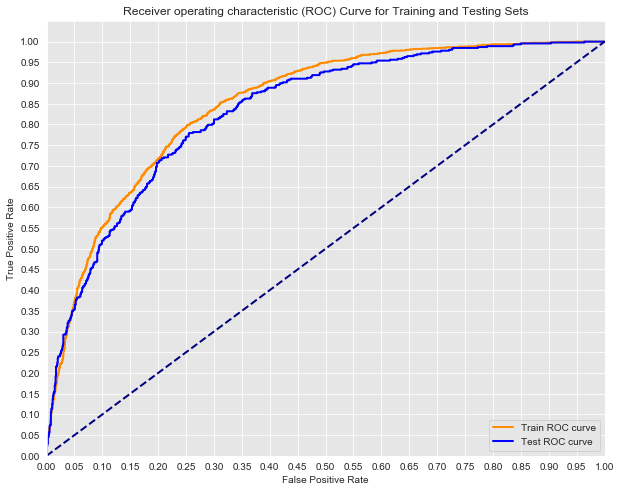

Training AUC: 0.84942
Testing AUC: 0.83321


In [26]:
roc_curve_and_auc(clf, X_train, X_test, y_train, y_test)

In [27]:
clf.coef_.round(2)

array([[-0.06,  0.01,  0.  ,  0.24,  0.08, -0.25,  0.82,  0.14,  0.69,
        -0.07, -0.07, -0.16, -0.07, -0.05, -0.07, -0.41, -0.07,  0.17,
        -0.8 , -1.39,  0.22, -0.04,  0.39, -0.07]])

In [28]:
# plot_feature_importances(clf)

### Logistic regression with syntetic samples

## SMOTE


In [31]:
smote = SMOTE()
scaled_X_train_smoted, y_train_smoted = smote.fit_sample(scaled_X_train, y_train)

## ADASYN

In [32]:
adasyn = ADASYN()
X_train_ada, y_train_ada = adasyn.fit_sample(X_train, y_train)

In [33]:
clf = LogisticRegression(fit_intercept=False, C=1e20, solver ='liblinear')
clf.fit(X_train_ada, y_train_ada)
y_pred_train = clf.predict(X_train_ada)
y_pred_test = clf.predict(X_test)

In [34]:
model_evaluation(X_train_ada, X_test, y_train_ada, y_test, y_pred_train, y_pred_test)

MODEL EVALUATION METRICS:
 -----------------------------------------------------
Confusion Matrix for train & test set: 

  Predicted  No Churn   Churn     All
0    Actual       NaN     NaN     NaN
1  No Churn    2723.0  1140.0  3863.0
2     Churn     773.0  3135.0  3908.0
3       All    3496.0  4275.0  7771.0
None 

  Predicted  No Churn  Churn     All
0    Actual       NaN    NaN     NaN
1  No Churn     886.0  414.0  1300.0
2     Churn      80.0  378.0   458.0
3       All     966.0  792.0  1758.0
None 

-----------------------------------------------------

Classification Report for train & test set
 
Train set
               precision    recall  f1-score   support

           0       0.78      0.70      0.74      3863
           1       0.73      0.80      0.77      3908

    accuracy                           0.75      7771
   macro avg       0.76      0.75      0.75      7771
weighted avg       0.76      0.75      0.75      7771
 

Test set
               precision    recall  f1-s

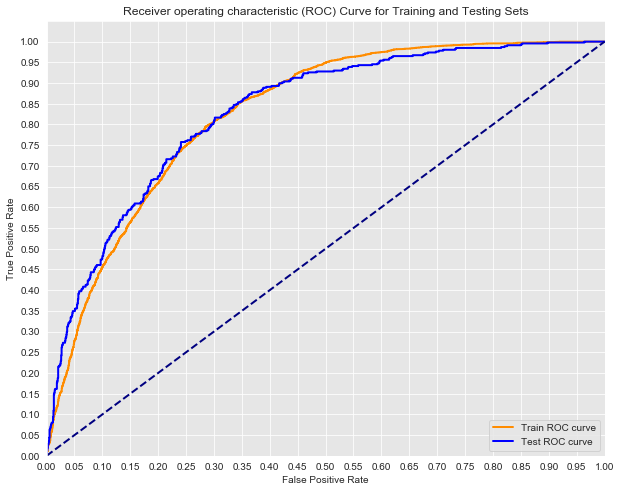

Training AUC: 0.82707
Testing AUC: 0.83024


In [35]:
roc_curve_and_auc(clf, X_train_ada, X_test, y_train_ada, y_test)

In [36]:
clf.coef_.round(2)

array([[-0.06,  0.01,  0.  ,  0.27,  0.15, -0.29,  0.94,  0.16,  0.57,
        -0.06, -0.06, -0.23, -0.06, -0.04, -0.06, -0.45, -0.06,  0.15,
        -0.93, -1.64,  0.23, -0.09,  0.42,  0.03]])

In [ ]:
# plot_feature_importances(clf)

In [39]:
X_train.columns

Index(['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen_1',
       'Partner_Yes', 'Dependents_Yes', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'TechSupport_No internet service',
       'TechSupport_Yes', 'StreamingTV_No internet service', 'StreamingTV_Yes',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

# L1 regression (Lasso and Ridge regularizations)

In [40]:
clf = SGDClassifier(penalty='elasticnet')
clf.fit(scaled_X_train_smoted, y_train_smoted)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None,
              penalty='elasticnet', power_t=0.5, random_state=None,
              shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
              warm_start=False)

In [41]:
y_pred_train = clf.predict(scaled_X_train_smoted)
y_pred_test = clf.predict(scaled_X_test)

In [42]:
model_evaluation(scaled_X_train_smoted, scaled_X_test, y_train_smoted, y_test, y_pred_train, y_pred_test)

MODEL EVALUATION METRICS:
 -----------------------------------------------------
Confusion Matrix for train & test set: 

  Predicted  No Churn   Churn     All
0    Actual       NaN     NaN     NaN
1  No Churn    2605.0  1258.0  3863.0
2     Churn     653.0  3210.0  3863.0
3       All    3258.0  4468.0  7726.0
None 

  Predicted  No Churn  Churn     All
0    Actual       NaN    NaN     NaN
1  No Churn     859.0  441.0  1300.0
2     Churn      86.0  372.0   458.0
3       All     945.0  813.0  1758.0
None 

-----------------------------------------------------

Classification Report for train & test set
 
Train set
               precision    recall  f1-score   support

           0       0.80      0.67      0.73      3863
           1       0.72      0.83      0.77      3863

    accuracy                           0.75      7726
   macro avg       0.76      0.75      0.75      7726
weighted avg       0.76      0.75      0.75      7726
 

Test set
               precision    recall  f1-s

In [43]:
clf = SGDClassifier(penalty='elasticnet',class_weight='balanced')
clf.fit(scaled_X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None,
              penalty='elasticnet', power_t=0.5, random_state=None,
              shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
              warm_start=False)

In [44]:
y_pred_train = clf.predict(scaled_X_train)
y_pred_test = clf.predict(scaled_X_test)

In [45]:
model_evaluation(scaled_X_train, scaled_X_test, y_train, y_test, y_pred_train, y_pred_test)

MODEL EVALUATION METRICS:
 -----------------------------------------------------
Confusion Matrix for train & test set: 

  Predicted  No Churn   Churn     All
0    Actual       NaN     NaN     NaN
1  No Churn    2901.0   962.0  3863.0
2     Churn     352.0  1059.0  1411.0
3       All    3253.0  2021.0  5274.0
None 

  Predicted  No Churn  Churn     All
0    Actual       NaN    NaN     NaN
1  No Churn     968.0  332.0  1300.0
2     Churn     119.0  339.0   458.0
3       All    1087.0  671.0  1758.0
None 

-----------------------------------------------------

Classification Report for train & test set
 
Train set
               precision    recall  f1-score   support

           0       0.89      0.75      0.82      3863
           1       0.52      0.75      0.62      1411

    accuracy                           0.75      5274
   macro avg       0.71      0.75      0.72      5274
weighted avg       0.79      0.75      0.76      5274
 

Test set
               precision    recall  f1-s

In [ ]:
len(clf.coef_)

# KNN Classifier

In [47]:
k_range = range(1, 26)

for k in k_range:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(scaled_X_train_smoted, y_train_smoted)
    y_pred_train = clf.predict(scaled_X_train_smoted)
    y_pred_test = clf.predict(scaled_X_test)
    
    print('------------')
    print(k)
    print('\nClassification Report for train & test set\n',
              '\nTrain set\n',
              classification_report(y_train_smoted, y_pred_train),
              '\n\nTest set\n',
              classification_report(y_test, y_pred_test))
    print('-----------------------------------------------\n')
    
    print ("f2 score for train and test set: \n ",
           round(fbeta_score(y_train_smoted, y_pred_train, 2.0),4), 
           round(fbeta_score(y_test, y_pred_test, 2.0),4))
    

------------
1

Classification Report for train & test set
 
Train set
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3863
           1       1.00      1.00      1.00      3863

    accuracy                           1.00      7726
   macro avg       1.00      1.00      1.00      7726
weighted avg       1.00      1.00      1.00      7726
 

Test set
               precision    recall  f1-score   support

           0       0.83      0.78      0.80      1300
           1       0.47      0.55      0.50       458

    accuracy                           0.72      1758
   macro avg       0.65      0.66      0.65      1758
weighted avg       0.74      0.72      0.73      1758

-----------------------------------------------

f2 score for train and test set: 
  0.998 0.5281
------------
2

Classification Report for train & test set
 
Train set
               precision    recall  f1-score   support

           0       0.90      1.00    

------------
11

Classification Report for train & test set
 
Train set
               precision    recall  f1-score   support

           0       0.90      0.72      0.80      3863
           1       0.76      0.92      0.83      3863

    accuracy                           0.82      7726
   macro avg       0.83      0.82      0.82      7726
weighted avg       0.83      0.82      0.82      7726
 

Test set
               precision    recall  f1-score   support

           0       0.89      0.68      0.77      1300
           1       0.45      0.76      0.57       458

    accuracy                           0.70      1758
   macro avg       0.67      0.72      0.67      1758
weighted avg       0.78      0.70      0.72      1758

-----------------------------------------------

f2 score for train and test set: 
  0.8844 0.669
------------
12

Classification Report for train & test set
 
Train set
               precision    recall  f1-score   support

           0       0.87      0.75  

------------
21

Classification Report for train & test set
 
Train set
               precision    recall  f1-score   support

           0       0.87      0.69      0.77      3863
           1       0.74      0.89      0.81      3863

    accuracy                           0.79      7726
   macro avg       0.80      0.79      0.79      7726
weighted avg       0.80      0.79      0.79      7726
 

Test set
               precision    recall  f1-score   support

           0       0.91      0.65      0.76      1300
           1       0.45      0.83      0.59       458

    accuracy                           0.70      1758
   macro avg       0.68      0.74      0.67      1758
weighted avg       0.79      0.70      0.72      1758

-----------------------------------------------

f2 score for train and test set: 
  0.8579 0.7111
------------
22

Classification Report for train & test set
 
Train set
               precision    recall  f1-score   support

           0       0.85      0.71 

# I chose n = 21 because it has a high recall value,  less overfitting. KNN is not the best algorithm in this data but I tried to make it as effiective as I can. High variance
I tried ADASYN here but it did not give better results than SMOTE.

In [48]:
clf = KNeighborsClassifier(n_neighbors=21)
clf.fit(scaled_X_train_smoted, y_train_smoted)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=21, p=2,
                     weights='uniform')

In [49]:
y_pred_train = clf.predict(scaled_X_train_smoted)
y_pred_test = clf.predict(scaled_X_test)

In [50]:
model_evaluation(scaled_X_train_smoted, scaled_X_test, y_train_smoted, y_test, y_pred_train, y_pred_test)

MODEL EVALUATION METRICS:
 -----------------------------------------------------
Confusion Matrix for train & test set: 

  Predicted  No Churn   Churn     All
0    Actual       NaN     NaN     NaN
1  No Churn    2658.0  1205.0  3863.0
2     Churn     413.0  3450.0  3863.0
3       All    3071.0  4655.0  7726.0
None 

  Predicted  No Churn  Churn     All
0    Actual       NaN    NaN     NaN
1  No Churn     846.0  454.0  1300.0
2     Churn      79.0  379.0   458.0
3       All     925.0  833.0  1758.0
None 

-----------------------------------------------------

Classification Report for train & test set
 
Train set
               precision    recall  f1-score   support

           0       0.87      0.69      0.77      3863
           1       0.74      0.89      0.81      3863

    accuracy                           0.79      7726
   macro avg       0.80      0.79      0.79      7726
weighted avg       0.80      0.79      0.79      7726
 

Test set
               precision    recall  f1-s

# SVM classifier

In [51]:
sample_X_train = X_train.sample(n=1000)
sample_y_train = y_train.sample(n=1000)

In [52]:
clf = SVC(kernel='linear', class_weight='balanced')
clf.fit(sample_X_train, sample_y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

In [ ]:
model_evaluation(X_train, X_test, y_train, y_test, y_pred_train, y_pred_test)

MODEL EVALUATION METRICS:
 -----------------------------------------------------
Confusion Matrix for train & test set: 

  Predicted  No Churn   Churn     All
0    Actual       NaN     NaN     NaN
1  No Churn    1305.0  2558.0  3863.0
2     Churn     532.0   879.0  1411.0
3       All    1837.0  3437.0  5274.0
None 

  Predicted  No Churn   Churn     All
0    Actual       NaN     NaN     NaN
1  No Churn     421.0   879.0  1300.0
2     Churn     181.0   277.0   458.0
3       All     602.0  1156.0  1758.0
None 

-----------------------------------------------------

Classification Report for train & test set
 
Train set
               precision    recall  f1-score   support

           0       0.71      0.34      0.46      3863
           1       0.26      0.62      0.36      1411

    accuracy                           0.41      5274
   macro avg       0.48      0.48      0.41      5274
weighted avg       0.59      0.41      0.43      5274
 

Test set
               precision    recall 

In [ ]:
roc_curve_and_auc(clf, X_train, X_test, y_train, y_test)

# SVM classifier smote gridsearch

In [ ]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
clf = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
  

clf.fit(scaled_X_train_smoted, y_train_smoted) 

In [ ]:
y_pred_train = clf.predict(scaled_X_train_smoted)
y_pred_test = clf.predict(scaled_X_test)

In [ ]:
model_evaluation(scaled_X_train_smoted, scaled_X_test, y_train_smoted, y_test, y_pred_train, y_pred_test)

In [ ]:
roc_curve_and_auc(clf, X_train, X_test, y_train, y_test)

# Naive Bayes

In [ ]:
clf = GaussianNB()
clf.fit(scaled_X_train_smoted, y_train_smoted)
y_pred_train = clf.predict(scaled_X_train_smoted)
y_pred_test = clf.predict(scaled_X_test)

In [ ]:
model_evaluation(scaled_X_train_smoted, scaled_X_test, y_train_smoted, y_test, y_pred_train, y_pred_test)

In [ ]:
# roc_curve_and_auc(clf, X_train, X_test, y_train, y_test)

In [ ]:
# clf.feature_importances_

In [ ]:
# plot_feature_importances(clf)